## Import Libraries

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

# Generate some data

In [2]:
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

In [3]:
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


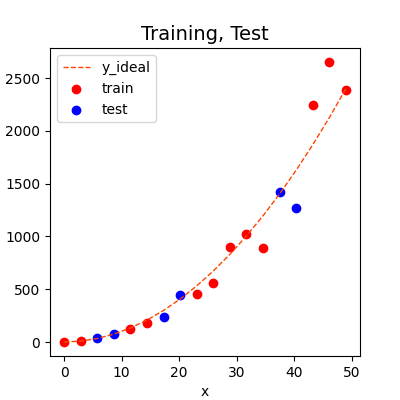

In [4]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = "blue",   label="test")
ax.legend(loc='upper left')
plt.show()

## Error calculation for model evaluation, linear regression

To evaluate model performance:
- Split the data into train and test
- Develop an error function to measure error

In [5]:
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err+=(y[i]-yhat[i])**2
    ### END CODE HERE ### 
    err/= 2*m
    return(err)

In [6]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

0.0050000000000000305

## Compare performance on training and test data
- Build a high degree polynomial to minimize training error
- Compute the error on training and test data

In [8]:
class lin_model:
    def __init__(self, degree, regularization = False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()
        
    def fit(self, X_train,y_train):
        ''' just fits the data. mapping and scaling are not repeated '''
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train )

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return(yhat)
    
    def mse(self, y, yhat):
        err = mean_squared_error(y,yhat)/2   #sklean doesn't have div by 2
        return (err)

In [9]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")


training err 58.01, test err 171215.01


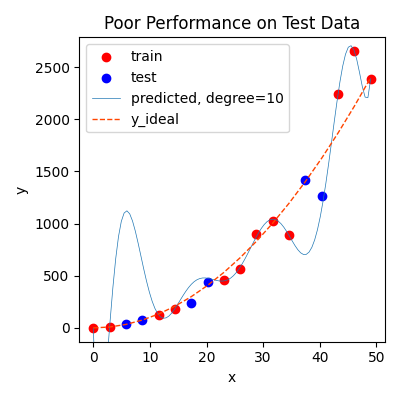

In [11]:
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.set_title("Poor Performance on Test Data",fontsize = 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.scatter(X_train, y_train, color = "red",           label="train")
    ax.scatter(X_test, y_test,       color = "blue", label="test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred,  lw=0.5, label=f"predicted, degree={degree}")
    ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

- The test error shows the model will not work on new data. Also, the test data cannot be used for guiding improvements in the model
- Thus, the data will now be separated into 3 groups - train, cv, test

## Bias and Variance

By training on different degrees of polynomials, the training and the cv errors can be evaluated

In [14]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


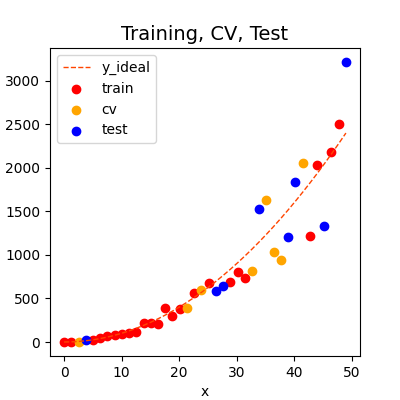

In [15]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = "orange", label="cv")
ax.scatter(X_test, y_test,   color = "blue",   label="test")
ax.legend(loc='upper left')
plt.show()

As the degree becomes too large, the cv error will start degrading

In [16]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

In [20]:
def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = "orange", label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = "blue")
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = "orange")
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = "magenta")
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                   color="darkred", lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()

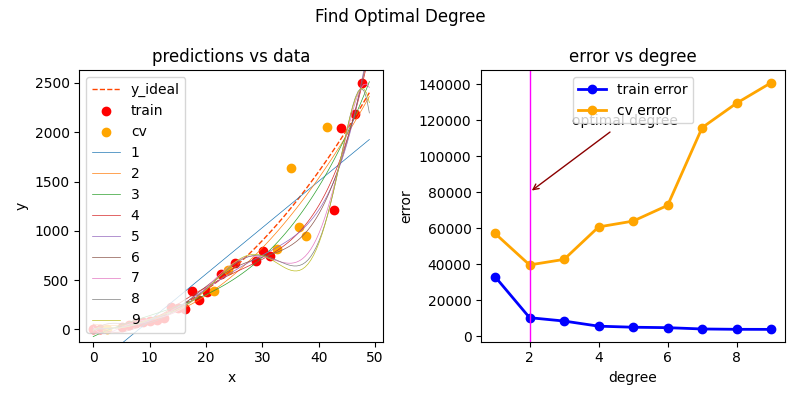

In [21]:
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used.

On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point.

on the right:
- the error on the trained data (blue) decreases as the model complexity increases as expected
- the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to generalize).

It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

## Tuning Regularization

Regualization can be utlilized to reduce overfitting. This paramater also needs to be tuned


In [22]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

In [25]:
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = "orange", label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = "blue")
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = "orange")
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()


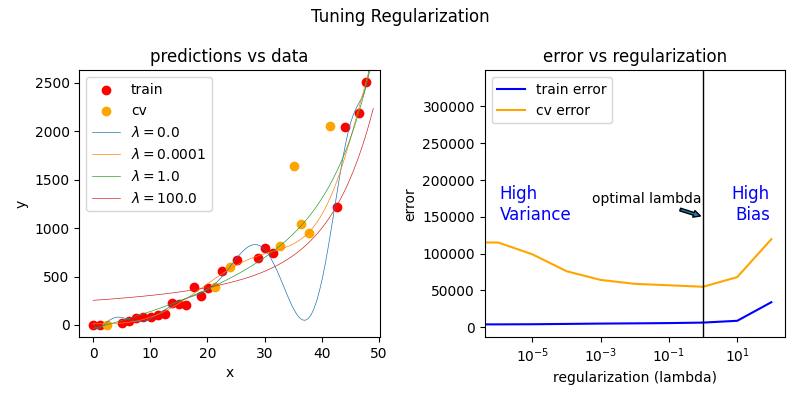

In [26]:
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Note: When a model is overfitting, getting additional data can improve performance

In [33]:
import matplotlib as mpl
def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m*np.arange(1,16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)     
    err_cv = np.zeros(num_steps)        
    y_pred = np.zeros((100,num_steps))     
    
    for i in range(num_steps):
        X, y, y_ideal, x_ideal = gen_data(m_range[i],5,0.7)
        x = np.linspace(0,int(X.max()),100)  
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

        lmodel = lin_model(degree)  # no regularization
        lmodel.fit(X_train, y_train)
        yhat = lmodel.predict(X_train)
        err_train[i] = lmodel.mse(y_train, yhat)
        yhat = lmodel.predict(X_cv)
        err_cv[i] = lmodel.mse(y_cv, yhat)
        y_pred[:,i] = lmodel.predict(x)
    return(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree)

def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = "orange", s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = "blue")

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = "blue")
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = "orange")
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
    ax[1].legend()
    plt.tight_layout()
    plt.show()  
    
dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

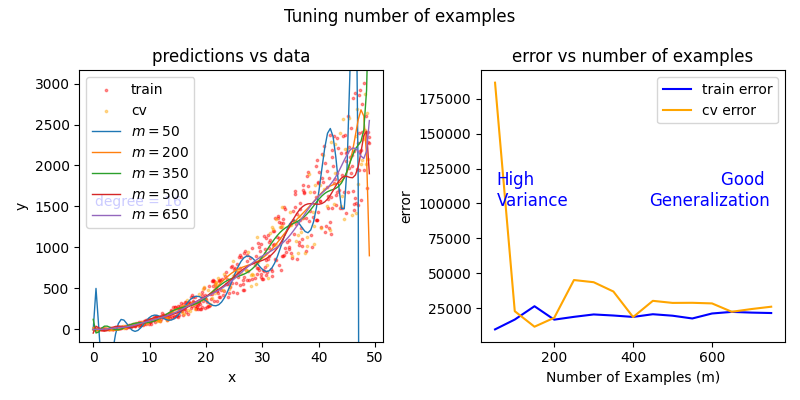

In [34]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

## Evaluating a Learning Algorithm (Neural Network)


In [37]:
from sklearn.datasets import make_blobs
def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std)

In [38]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs() 

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


In [40]:
def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')

In [42]:
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw) 
    ax.axis('tight')


In [45]:
def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

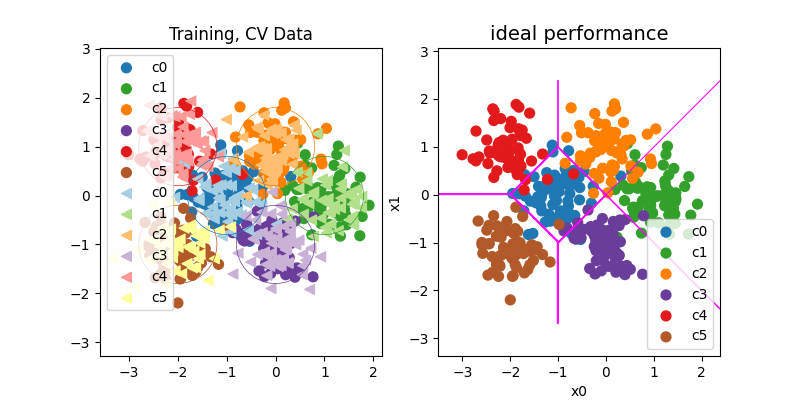

In [46]:
def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Training, CV Data")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    #make a model for plotting routines to call
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = "magenta", lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()
    
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

## Evaluating categorical model by calculating classification error

In [47]:
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if(yhat[i]!=y[i]):
            incorrect+=1
    ### END CODE HERE ### 
    cerr=incorrect/m
    return(cerr)

In [48]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250


Below we have 2 models - simple, complex

1. Complex model
- Dense layer with 120 units, Relu activation
- Dense layer with 40 units, Relu activation
- Dense layer with 6 units, Linear activation
- loss = SparseCategoryCrossEntropy, from_logits=True
- Adam optimizer with learning rate = 0.01

2. Simple model
- Dense layer with 6 units, Relu activation
- Dense layer with 6 units, Linear activation
- loss = SparseCategoryCrossEntropy, from_logits=True
- Adam optimizer with learning rate = 0.01

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ### 
    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    ### END CODE HERE ### 
)

model.fit(
    X_train, y_train,
    epochs=1000
)

In [ ]:
model.summary()

In [ ]:
def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    #plot the decison boundary.
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("training data", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("cross-validation data", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes, 
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1"); 
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()


def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      err: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:
            incorrect += 1
    err = incorrect/m
    return(err)

In [ ]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [ ]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

#### simple model

In [ ]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    ### START CODE HERE ### 
)

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)

In [ ]:
# BEGIN UNIT TEST
model_s.summary()

In [ ]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [ ]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

# Regularization

Reconstruct your complex model, but this time include regularization. Below, compose a three-layer model:

- Dense layer with 120 units, relu activation, kernel_regularizer=tf.keras.regularizers.l2(0.1)
- Dense layer with 40 units, relu activation, kernel_regularizer=tf.keras.regularizers.l2(0.1)
- Dense layer with 6 units and a linear activation. Compile using
- loss with SparseCategoricalCrossentropy, remember to use from_logits=True
- Adam optimizer with learning rate of 0.01.

In [ ]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(6, activation="linear")
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    ### START CODE HERE ### 
)

In [ ]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

In [ ]:
# BEGIN UNIT TEST
model_r.summary()

In [ ]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [ ]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

### Iterate to find optimal regularization value


In [ ]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")

In [50]:
"""
assignment_utils.py
contains routines used by C2_W3 Assignments 
"""
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.widgets import Button, CheckButtons
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

from ipywidgets import Output
np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
# --- Assignment ----------------------------------------
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std)

class lin_model:
    def __init__(self, degree, regularization = False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()
        
    def fit(self, X_train,y_train):
        ''' just fits the data. mapping and scaling are not repeated '''
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train )

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return(yhat)
    
    def mse(self, y, yhat):
        err = mean_squared_error(y,yhat)/2   #sklean doesn't have div by 2
        return (err)
     
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.set_title("Poor Performance on Test Data",fontsize = 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.scatter(X_train, y_train, color = "red",           label="train")
    ax.scatter(X_test, y_test,       color = dlc["dlblue"], label="test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred,  lw=0.5, label=f"predicted, degree={degree}")
    ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = dlc["dlblue"])
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = dlc["dlorange"])
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = dlc["dlmagenta"])
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                   color=dlc['dldarkred'], lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()
    
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m*np.arange(1,16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)     
    err_cv = np.zeros(num_steps)        
    y_pred = np.zeros((100,num_steps))     
    
    for i in range(num_steps):
        X, y, y_ideal, x_ideal = gen_data(m_range[i],5,0.7)
        x = np.linspace(0,int(X.max()),100)  
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

        lmodel = lin_model(degree)  # no regularization
        lmodel.fit(X_train, y_train)
        yhat = lmodel.predict(X_train)
        err_train[i] = lmodel.mse(y_train, yhat)
        yhat = lmodel.predict(X_cv)
        err_cv[i] = lmodel.mse(y_cv, yhat)
        y_pred[:,i] = lmodel.predict(x)
    return(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree)

def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = dlc["dlblue"])

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend()
    plt.tight_layout()
    plt.show()  
    
dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')


#Plot a multi-class categorical decision boundary
# This version handles a non-vector prediction (adds a for-loop over points)
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw) 
    ax.axis('tight')

def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Training, CV Data")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    #make a model for plotting routines to call
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()
    
    
def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    #plot the decison boundary.
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("training data", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("cross-validation data", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes, 
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1"); 
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()


def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      err: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:
            incorrect += 1
    err = incorrect/m
    return(err)

def plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv):
    err_train = np.zeros(len(lambdas))
    err_cv = np.zeros(len(lambdas))
    for i in range(len(models)):
        err_train[i] = eval_cat_err(y_train,np.argmax( models[i](X_train), axis=1))
        err_cv[i] = eval_cat_err(y_cv, np.argmax( models[i](X_cv), axis=1))

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax.set_title("error vs regularization",fontsize = 12)
    ax.plot(lambdas, err_train, marker='o', label="train error", color = dlc["dlblue"])
    ax.plot(lambdas, err_cv,    marker='o', label="cv error",    color = dlc["dlorange"])
    ax.set_xscale('log')
    ax.set_ylim(*ax.get_ylim())
    ax.set_xlabel("Regularization (lambda)",fontsize = 14)
    ax.set_ylabel("Error",fontsize = 14)
    ax.legend()
    fig.suptitle("Tuning Regularization",fontsize = 14)
    ax.text(0.05,0.14,"Training Error\nlower than CV",fontsize=12, ha='left',transform=ax.transAxes,color = dlc["dlblue"])
    ax.text(0.95,0.14,"Similar\nTraining, CV",    fontsize=12, ha='right',transform=ax.transAxes,color = dlc["dlblue"])
    plt.show()
 
# not used but will calculate the erro assuming an equal distance
def err_all_equal(X_train,X_cv,X_test, y_train,y_cv,y_test, centers):
    X_all = np.concatenate((X_train,X_cv,X_test), axis=0)
    y_all = np.concatenate((y_train,y_cv,y_test), axis=0)
    m = len(X_all)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X_all[i], centers)
    err_all = eval_cat_err(y_all, y_eq)
    return(err_all)

def plt_compare(X,y, classes, simple, regularized, centers):
    plt.close("all")
    fig,ax = plt.subplots(1,3, figsize=(8,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

  #plt simple   
    plot_cat_decision_boundary(ax[0], X, simple,  vector=True)
    ax[0].set_title("Simple Model", fontsize=14)
    plt_mc_data(ax[0], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt regularized   
    plot_cat_decision_boundary(ax[1], X, regularized,  vector=True)
    ax[1].set_title("Regularized Model", fontsize=14)
    plt_mc_data(ax[1], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[1].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt ideal
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_deci

In [ ]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

In [ ]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)